In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
df = pyam.IamDataFrame(pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
]))

In [4]:
meta = pd.merge(
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv'),
    pd.read_csv(data_path / 'additional_analysis_metadata.csv'),
    on=['model', 'scenario'], how='inner'
)

In [5]:
df.set_meta(meta)

# Summarize Key Mitigation Statistics

In [6]:
variable_templates = [
    'AR6 climate diagnostics|Infilled|Emissions|{gas}', # as reported in AR6
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}|Direct Only', # reanalyzed by OSCAR
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}', # reanalyzed by OSCAR including NGHGI adjustment 
]

In [7]:
def summarize(data, variable_start, gas, name, dataonly=False):
    print(name)
    cols = [variable_start + template.format(gas=gas) for template in variable_templates]
    headers = ['AR6 Statistics', 'Pathways with OSCAR Direct Effects', 'Pathways with OSCAR Direct & Indirect Effects']
    for col in cols:
        if not col in data:
            raise ValueError(f'{col} not in data columns')
    ret = (
        data
        .query("Category in ['C1', 'C2', 'C3']")
        .replace({'Category': {'C1': '1.5C', 'C2': '1.5C-OS', 'C3': '2C'}})
        .rename(columns={c: h for c, h in zip(cols, headers)})
        [headers + ['Category']]
        .groupby('Category')
        .describe(percentiles=(0.05, 0.5, 0.95))
    )
    if not dataonly:
        ret = (
            ret
            .stack(level=-2)
            [['50%', '5%', '95%']]
            .fillna(2100)
            .astype(int)
            .apply(lambda col: f"{col['50%']} ({col['5%']}-{col['95%']})", axis=1)
            .to_frame(name=name)
            .loc[['1.5C', '1.5C-OS', '2C'], headers, :]
        )
    return ret

In [8]:
to_summarize = {
    ('Carbon Budget for ', 'CO2'): 'Carbon Budget from 2020',
    ('2030 Emission Reductions for ', 'CO2'): 'CO2 Emissions Reductions (2020-2030)',
    ('Interpolated Net-Zero Year for ', 'CO2'): 'Net-zero CO2 Year',
    ('Interpolated Net-Zero Year for ', 'Kyoto Gases'): 'Net-zero GHG Year',
}

In [9]:
table = pd.concat([
    summarize(df.meta, variable_start, gas, name)
    for (variable_start, gas), name in to_summarize.items()
], axis=1).T
table.to_excel('mitigation_outcomes.xlsx')
table

Carbon Budget from 2020
CO2 Emissions Reductions (2020-2030)
Net-zero CO2 Year
Net-zero GHG Year


C:\Users\gidden\Miniconda3\envs\pyam\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\gidden\Miniconda3\envs\pyam\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\gidden\Miniconda3\envs\pyam\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Category                                          1.5C  \
                                        AR6 Statistics   
Carbon Budget from 2020                  507 (341-648)   
CO2 Emissions Reductions (2020-2030)        49 (35-67)   
Net-zero CO2 Year                     2052 (2038-2067)   
Net-zero GHG Year                     2100 (2052-2100)   

Category                                                                 \
                                     Pathways with OSCAR Direct Effects   
Carbon Budget from 2020                                   473 (319-620)   
CO2 Emissions Reductions (2020-2030)                         52 (35-67)   
Net-zero CO2 Year                                      2050 (2040-2060)   
Net-zero GHG Year                                      2066 (2050-2090)   

Category                                                                            \
                                     Pathways with OSCAR Direct & Indirect Effects   
Carbon Budget from 2020                                              392 (262-528)   
CO2 Emissions Reductions (2020-2030)                                    56 (39-73)   
Net-zero CO2 Year                                                 2047 (2037-2057)   
Net-zero GHG Year                                                 2067 (2049-2088)   

Category                                       1.5C-OS  \
                                        AR6 Statistics   
Carbon Budget from 2020                  718 (522-933)   
CO2 Emissions Reductions (2020-2030)         26 (1-49)   
Net-zero CO2 Year                     2058 (2047-2066)   
Net-zero GHG Year                     2073 (2057-2100)   

Category                                                                 \
                                     Pathways with OSCAR Direct Effects   
Carbon Budget from 2020                                  702 (497-1000)   
CO2 Emissions Reductions (2020-2030)                          25 (0-49)   
Net-zero CO2 Year                                      2057 (2047-2068)   
Net-zero GHG Year                                      2073 (2056-2089)   

Category                                                                            \
                                     Pathways with OSCAR Direct & Indirect Effects   
Carbon Budget from 2020                                              594 (422-865)   
CO2 Emissions Reductions (2020-2030)                                     29 (1-52)   
Net-zero CO2 Year                                                 2054 (2045-2065)   
Net-zero GHG Year                                                 2074 (2054-2097)   

Category                                            2C  \
                                        AR6 Statistics   
Carbon Budget from 2020                 881 (618-1089)   
CO2 Emissions Reductions (2020-2030)         21 (1-45)   
Net-zero CO2 Year                     2070 (2058-2090)   
Net-zero GHG Year                     2100 (2078-2100)   

Category                                                                 \
                                     Pathways with OSCAR Direct Effects   
Carbon Budget from 2020                                  838 (542-1100)   
CO2 Emissions Reductions (2020-2030)                          21 (1-50)   
Net-zero CO2 Year                                      2068 (2051-2088)   
Net-zero GHG Year                                      2082 (2069-2096)   

Category                                                                            
                                     Pathways with OSCAR Direct & Indirect Effects  
Carbon Budget from 2020                                              703 (445-936)  
CO2 Emissions Reductions (2020-2030)                                     25 (4-55)  
Net-zero CO2 Year                                                 2064 (2049-2084)  
Net-zero GHG Year                                                 2082 (2066-2098)

In [10]:
budgets = summarize(df.meta, 'Carbon Budget for ', 'CO2', 'Carbon Budget from 2020', dataonly=True).stack()
1 - budgets['Pathways with OSCAR Direct & Indirect Effects'] / budgets['Pathways with OSCAR Direct Effects']

Carbon Budget from 2020


Category       
1.5C      count    0.000000
          mean     0.163203
          std      0.130028
          min      0.301821
          5%       0.179988
          50%      0.170250
          95%      0.149395
          max      0.154516
1.5C-OS   count    0.000000
          mean     0.147342
          std      0.110487
          min      0.160605
          5%       0.152412
          50%      0.154522
          95%      0.135265
          max      0.132219
2C        count    0.005128
          mean     0.162748
          std      0.142802
          min      0.192574
          5%       0.180185
          50%      0.160563
          95%      0.149163
          max      0.138996
dtype: float64

# Net-zero timings compared to a constant offset of 3.7 Gt CO2

Here we calculate the difference between net-zero timings between the dynamic estimation of indirect effects vs. applying a constant offset value


In [11]:
def calc_nz(df, v):
    data = (
         df
        .filter(region='World', variable=v)
        .filter(year=range(2020, 2101))
        .timeseries()
        .T
        .lt(1e-2)
        .idxmax()
        .reset_index(level=['region', 'variable', 'unit'], drop=True)
    )
    data[data == 2020] = pd.NA
    return data    

In [12]:
v = 'CO2-constant offset'
offsetdf = df.subtract('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only', 3.7e3, name=v, ignore_units='Mt CO2/yr')
offsetdf.set_meta(calc_nz(offsetdf, v), name=f'Interpolated Net-Zero Year for {v}')

In [13]:
offsetdf.meta['Offset Year Delta'] = (
    offsetdf.meta['Interpolated Net-Zero Year for AR6 Reanalysis|OSCARv3.2|Emissions|CO2'] -
    offsetdf.meta['Interpolated Net-Zero Year for CO2-constant offset']
)

In [14]:
offsetdf.meta.groupby('Category')['Offset Year Delta'].count()

Category
C1    210
C2    318
C3    582
C4    100
C5     68
C6      0
C7      0
C8      0
Name: Offset Year Delta, dtype: int64

In [15]:
(
    offsetdf.meta
    .groupby('Category')['Offset Year Delta']
    .describe(percentiles=(0.05, 0.5, 0.95))
    [['50%', '5%', '95%']]
)

,50%,5%,95%
Category,,,
C1,2.0,0.0,7.00
C2,2.0,0.0,7.00
C3,4.0,1.0,15.00
C4,4.0,1.0,13.05
C5,4.0,1.0,9.95
C6,NaN,NaN,NaN
C7,NaN,NaN,NaN
C8,NaN,NaN,NaN


# Figure

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def figure_data(data, variable_start, gas, name):
    print(name)
    cols = [variable_start + template.format(gas=gas) for template in variable_templates]
    headers = ['AR6 Statistics', 'Pathways with OSCAR Direct Effects', 'Pathways with OSCAR Direct & Indirect Effects']
    for col in cols:
        if not col in data:
            raise ValueError(f'{col} not in data columns')
    ret = (
        data
        .query("Category in ['C1', 'C2', 'C3']")
        .replace({'Category': {'C1': '1.5C', 'C2': '1.5-OS', 'C3': '2C'}})
        .rename(columns={c: h for c, h in zip(cols, headers)})
        [headers + ['Category']]
    )
    ret = (
        ret
        .dropna()
        .sort_values(by='AR6 Statistics', ascending=True)
        .reset_index(drop=True)
        .reset_index()
    )
    return ret

In [18]:
def scatter_compare(data, right='Pathways with OSCAR Direct Effects', left="Pathways with OSCAR Direct & Indirect Effects"):
    fig, ax = plt.subplots(figsize=(6, 8))

    sns.scatterplot(
        data=data, 
        x=right, y="index", hue='Category',
        label=right,
        marker='o', size=2, ax=ax, 
    )
    sns.scatterplot(
        data=data, 
        x=left, y="index", hue='Category',
        label=left,
        marker='^', size=2, ax=ax,
    )
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('')
    h, l = ax.get_legend_handles_labels()
    end = 2
    ax.legend(h[::4], l[::4], **{'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.05), 'ncol': 2})
    return fig, ax

Carbon Budget from 2020


Text(0.5, 1.0, 'Cumulative CO2 2020-NetZero')

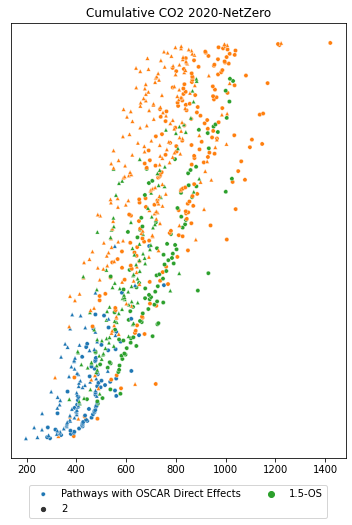

In [19]:
data = figure_data(df.meta, 'Carbon Budget for ', 'CO2', 'Carbon Budget from 2020')
fig, ax = scatter_compare(data)
ax.set_title('Cumulative CO2 2020-NetZero')

In [20]:
data.Category.unique()

array(['1.5C', '2C', '1.5-OS'], dtype=object)

Net-zero CO2 Year


Text(0.5, 1.0, 'Net-Zero Year')

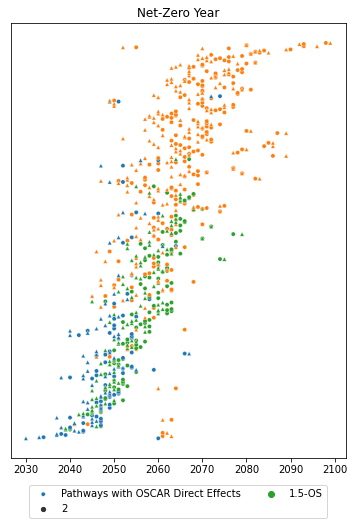

In [21]:
data = figure_data(df.meta, 'Interpolated Net-Zero Year for ', 'CO2', 'Net-zero CO2 Year')
fig, ax = scatter_compare(data)
ax.set_title('Net-Zero Year')

In [22]:
data.head()

,index,AR6 Statistics,Pathways with OSCAR Direct Effects,Pathways with OSCAR Direct & Indirect Effects,Category
0,0,2030.0,2060.0,2030.0,1.5C
1,1,2033.0,2034.0,2033.0,1.5C
2,2,2035.0,2061.0,2063.0,2C
3,3,2037.0,2039.0,2037.0,1.5C
4,4,2037.0,2038.0,2037.0,1.5C


Category      
1.5-OS    0.05    -5.0
          0.50     0.0
          0.95     5.0
1.5C      0.05    -2.0
          0.50     1.5
          0.95    12.1
2C        0.05   -11.0
          0.50     3.0
          0.95    12.0
Name: diff, dtype: float64

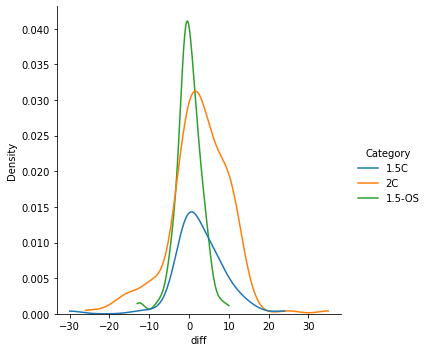

In [23]:
diff = data['AR6 Statistics'] - data['Pathways with OSCAR Direct Effects']
diff.name = 'Difference'
data['diff'] = diff
#ax = sns.displot(data, x="diff", hue="Category", kind="kde", multiple="stack")
#ax = sns.displot(data, x="diff", kde=True, hue="Category")
ax = sns.displot(data, x="diff", hue="Category", kind="kde", cut=0)
#ax.set_xlim((-5, 10))
data.groupby('Category')['diff'].quantile([0.05, 0.5, 0.95])

Category      
1.5-OS    0.05    1.0
          0.50    2.0
          0.95    4.0
1.5C      0.05    1.0
          0.50    3.0
          0.95    5.0
2C        0.05   -1.0
          0.50    3.0
          0.95    6.6
Name: diff, dtype: float64

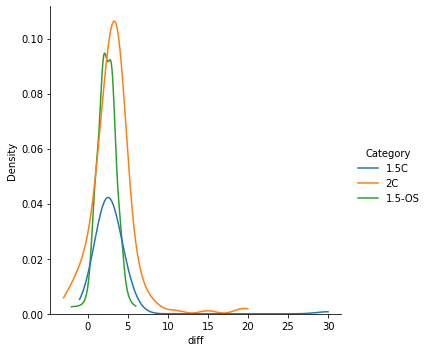

In [24]:
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
diff.name = 'Difference'
data['diff'] = diff
#ax = sns.displot(data, x="diff", hue="Category", kind="kde", multiple="stack")
#ax = sns.displot(data, x="diff", kde=True, hue="Category")
ax = sns.displot(data, x="diff", hue="Category", kind="kde", cut=0)
#ax.set_xlim((-5, 10))
data.groupby('Category')['diff'].quantile([0.05, 0.5, 0.95])

In [25]:
data.head()

,index,AR6 Statistics,Pathways with OSCAR Direct Effects,Pathways with OSCAR Direct & Indirect Effects,Category,diff
0,0,2030.0,2060.0,2030.0,1.5C,30.0
1,1,2033.0,2034.0,2033.0,1.5C,1.0
2,2,2035.0,2061.0,2063.0,2C,-2.0
3,3,2037.0,2039.0,2037.0,1.5C,2.0
4,4,2037.0,2038.0,2037.0,1.5C,1.0
